In [65]:
import numpy as np
from importlib import reload
import interpolate_fhat_Jhat as intf
import matplotlib.pyplot as plt
import calculate_Gamma as Gamma
from scipy.interpolate import interp1d, splev, splrep
from scipy.optimize import differential_evolution, curve_fit
from statistics import stdev

### LCDM predictions

In [67]:
Omega_m0=0.3111

z_range = np.linspace(0,2,100)
fhat_LCDM = Gamma.fhat_LCDM(z_range) 
fhat_der_LCDM = np.gradient(fhat_LCDM, z_range, axis=0, edge_order=2 ) #derivative wrt z)
    
dlnf_LCDM = fhat_der_LCDM * (1+z_range)/fhat_LCDM    

Jhat_LCDM = Gamma.Jhat_LCDM(z_range)
Jhat_der_LCDM = np.gradient(Jhat_LCDM, z_range, axis=0, edge_order=2 ) #derivative wrt z

H = Gamma.E(z_range) #not the conformal one
confH = Gamma.E(z_range)/(1+z_range) #the conformal one

Hprime = Gamma.Hprime(z_range) 
    #Note that this is the derivative by ln(a), which is related to the derivative by ln(1+z) by a minus sign
dHdz = 3/2*Omega_m0*(1+z_range)**2/H

Omega_mz = Gamma.Omega_m(z_range)
D_Omega_m = 3*Omega_mz/(1+z_range)-2*Omega_mz*dHdz/H

In [8]:
fhat_der = interp1d(z_range, fhat_der_LCDM)

In [9]:
dlnf_LCDM = fhat_der_LCDM*(1+z_range)/fhat_LCDM

### Jhat LSST and fhat DESI predictions

In [10]:
#Jhat from LSST, see arXiv:2312.06434 
z_LSST = np.array([0.25, 0.38, 0.51, 0.65, 0.79, 0.95, 1.13, 1.35, 1.7, 2.1])

#See Tables 2.3 & 2.5 for the DESI values (for fhat)
z_DESI = np.array([0.15, 0.25, 0.35, 0.45, #values belonging to Bright Galaxy sample
                  0.65, 0.75, 0.85, 0.95, 1.05,
                  1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85]) #removed first entry z=0.05 

In [11]:
N=4
z_nodes = np.linspace(z_DESI[0],z_DESI[-1],N) #np.linspace(0,2,4)

In [12]:
spl = splrep(z_nodes, Gamma.fhat_LCDM(z_nodes))
fhat_spline_LCDM=splev(z_range, spl)

spl = splrep(z_nodes, Gamma.Jhat_LCDM(z_nodes))
Jhat_spline_LCDM=splev(z_range, spl)

fhat_der_spline_LCDM = np.gradient(fhat_spline_LCDM, z_range, axis=0, edge_order=2 ) #derivative wrt z
Jhat_der_spline_LCDM = np.gradient(Jhat_spline_LCDM, z_range, axis=0, edge_order=2 ) #derivative wrt z

In [13]:
Jhat_fiducial = Gamma.Jhat_LCDM(z_LSST) 
print(Jhat_fiducial) 

fhat_fiducial = Gamma.fhat_LCDM(z_DESI)
print(fhat_fiducial)

[0.33308588 0.36038033 0.37813244 0.38828661 0.39120849 0.38818494
 0.37945921 0.36448692 0.33701792 0.3059385 ]
[0.45617895 0.46803851 0.47375756 0.47450166 0.46531274 0.45714533
 0.4475127  0.4369238  0.42576887 0.41434126 0.40285732 0.39147348
 0.38030021 0.36941322 0.35886212 0.34867723 0.33887466]


In [14]:
Jhat_covariance_pess = np.array([
    [2.57951701e-06, 3.43714013e-06, 3.78596653e-06, 3.97457043e-06, 4.18816362e-06, 4.39505164e-06, 4.47790648e-06, 4.47700806e-06, 4.24858437e-06, 3.87759857e-06],
    [3.43714013e-06, 5.76832795e-06, 6.54476977e-06, 6.95571576e-06, 7.45270358e-06, 7.92270577e-06, 8.13695089e-06, 8.20293470e-06, 7.69384687e-06, 6.90754476e-06],
    [3.78596653e-06, 6.54476977e-06, 8.11838970e-06, 8.63298312e-06, 9.17778834e-06, 9.77833733e-06, 1.00747736e-05, 1.01941775e-05, 9.52407086e-06, 8.50424121e-06],
    [3.97457043e-06, 6.95571576e-06, 8.63298312e-06, 9.83424932e-06, 1.03745319e-05, 1.09043993e-05, 1.12436536e-05, 1.14074618e-05, 1.06360913e-05, 9.46716355e-06],
    [4.18816362e-06, 7.45270358e-06, 9.17778834e-06, 1.03745319e-05, 1.16363619e-05, 1.20980641e-05, 1.22994565e-05, 1.24745875e-05, 1.16153781e-05, 1.03213691e-05],
    [4.39505164e-06, 7.92270577e-06, 9.77833733e-06, 1.09043993e-05, 1.20980641e-05, 1.34344629e-05, 1.34470640e-05, 1.34194239e-05, 1.24643638e-05, 1.10630734e-05],
    [4.47790648e-06, 8.13695089e-06, 1.00747736e-05, 1.12436536e-05, 1.22994565e-05, 1.34470640e-05, 1.45726282e-05, 1.41793590e-05, 1.29215851e-05, 1.14578205e-05],
    [4.47700806e-06, 8.20293470e-06, 1.01941775e-05, 1.14074618e-05, 1.24745875e-05, 1.34194239e-05, 1.41793590e-05, 1.54847524e-05, 1.35132383e-05, 1.16759455e-05],
    [4.24858437e-06, 7.69384687e-06, 9.52407086e-06, 1.06360913e-05, 1.16153781e-05, 1.24643638e-05, 1.29215851e-05, 1.35132383e-05, 1.53255587e-05, 1.18286623e-05],
    [3.87759857e-06, 6.90754476e-06, 8.50424121e-06, 9.46716355e-06, 1.03213691e-05, 1.10630734e-05, 1.14578205e-05, 1.16759455e-05, 1.18286623e-05, 2.78093215e-05]
])

In [15]:
Jhat_reco_pess = {
    'mean' : Jhat_fiducial,
    'cov' : Jhat_covariance_pess,
}

In [59]:
# Note: These are the absolute errors
fhat_errors_opt = np.array([5.25, 3.25, 2.60, 3.77, 1.57, 1.01, 1.01, 0.99, 
                            1.11, 1.14, 1.16, 1.73, 1.87, 2.27, 3.61, 6.81, 7.07])/100*fhat_fiducial #removed first entry 14.08
fhat_covariance_opt = np.diag(fhat_errors_opt**2)

fhat_data_future = {
    'z' : z_DESI,
    'mean' : fhat_fiducial,
    'cov' : fhat_covariance_opt,
    'err' : fhat_errors_opt
}

In [60]:
Jhat_errors_pess = np.sqrt(np.diag(Jhat_covariance_pess))

#### Checking the AIC / BIC for the spline interpolation

In [18]:
N=3
[best_fit_values_mock, covariance_matrix_mock] = intf.minuit_spline(np.linspace(0,2,N), z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
fhat_splineN_reco = intf.spline_interpolation(best_fit_values_mock, covariance_matrix_mock, zarray = np.linspace(0,2,N))

In [19]:
def IC_mock(best_fit_values, zarray, k=3):
    chi_squared = intf.chi_squared_spline(best_fit_values, zarray, k=k,  z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt, fhat_data_covariance = fhat_covariance_opt)
    AIC = 2*len(zarray)+2*chi_squared
    BIC= np.log(len(z_DESI))*len(zarray)+2*chi_squared
    return [chi_squared, AIC, BIC]    

In [20]:
# Define the objective function to minimize
def objective(zarray):
    zarray = np.sort(np.ravel(zarray))
    best_fit_values_test, _ = intf.minuit_spline(zarray, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
    return intf.chi_squared_spline(best_fit_values_test, np.sort(zarray), z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt) # Sort to ensure increasing order

# Bounds for each of the 5 redshift values (assuming they must be in [0,2])
bounds = [(0, 2)] * 5  # 5 values, each between 0 and 2

# Run differential evolution to find the optimal placement
result = differential_evolution(objective, bounds, strategy='best1bin', 
                                popsize=15, tol=1e-6, maxiter=10)

# Optimal zarray values
optimal_zarray = np.sort(result.x)

print("Optimal zarray:", optimal_zarray)
print("Minimum chi-squared:", result.fun)

Optimal zarray: [0.40700811 0.49449265 0.87397379 1.19420046 1.58587492]
Minimum chi-squared: 0.0065788008094582375


In [21]:
best_fit_values_optimal, _ = intf.minuit_spline(optimal_zarray, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
print("Minimum AIC:", IC_mock(best_fit_values_optimal, optimal_zarray))

Minimum AIC: [0.0065788008094582375, 10.013157601618916, 14.179224321899996]


In [22]:
AIC_values=[]
BIC_values=[]
chi_squared_values=[]
k=3

for n in range(3,15):
    z_test=np.linspace(0,2,n)
    [best_fit_values_test, covariance_matrix_test] = intf.minuit_spline(z_test, k=k, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
    [chi_squared, AIC, BIC]=IC_mock(best_fit_values_test, z_test, k=k)
    chi_squared_values.append(chi_squared)
    AIC_values.append(AIC)
    BIC_values.append(BIC)
    
print(chi_squared_values)
print(AIC_values)
print(BIC_values)

[5.261730673041713, 0.3380236826735858, 0.017227785570982933, 0.0012091686511980222, 6.692545318956491e-05, 7.531461287031104e-05, 0.00011922313043206793, 1.2840908469814447e-06, 6.0063407305346156e-06, 2.0568309203586028e-05, 6.934529751655553e-06, 1.3454417074174781e-05]
[16.523461346083426, 8.676047365347172, 10.034455571141965, 12.002418337302396, 14.00013385090638, 16.00015062922574, 18.000238446260862, 20.000002568181692, 22.00001201268146, 24.000041136618407, 26.000013869059504, 28.000026908834148]
[19.023101378252075, 12.008900741572036, 14.200522291423045, 17.001698401639693, 19.832627259299894, 22.66585738167547, 25.499158542766807, 28.332136008743852, 31.165358797299838, 33.998601265293004, 36.83178734179031, 39.66501372562118]


#### Spline reconstruction 

In [23]:
# Spline interpolation
node_values = np.array([0.1, 0.8, 0.85761194, 1.0, 1.8])

# Generate best fit values (for fhat at nodes) and cov matrix
[best_fit_spline, cov_spline] = intf.minuit_spline(node_values, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt )

# Interpolate over the whole redshift range by generating 1000 samples
fhat_spline_reco = intf.spline_interpolation(best_fit_spline, cov_spline, zarray = node_values, z_range = z_range, return_covariance = True)
fhat_spline_reco_LSST = intf.spline_interpolation(best_fit_spline, cov_spline, zarray = node_values, z_range = z_LSST, return_covariance = True)
fhat_spline_reco_nodes = intf.spline_interpolation(best_fit_spline, cov_spline, zarray = node_values, z_range = node_values, return_covariance = True)

In [24]:
# Spline interpolation with 4 knots
node_values2 = np.array([0.1, 0.86, 1.0, 1.8])

# Generate best fit values (for fhat at nodes) and cov matrix
[best_fit_spline2, cov_spline2] = intf.minuit_spline(node_values2, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt )

# Interpolate over the whole redshift range by generating 1000 samples
fhat_spline_reco2 = intf.spline_interpolation(best_fit_spline2, cov_spline2, zarray = node_values2, z_range = z_range, return_covariance = True)
fhat_spline_reco_LSST2 = intf.spline_interpolation(best_fit_spline2, cov_spline2, zarray = node_values2, z_range = z_LSST, return_covariance = True)
fhat_spline_reco_nodes2 = intf.spline_interpolation(best_fit_spline2, cov_spline2, zarray = node_values2, z_range = node_values2, return_covariance = True)

In [25]:
fhat_stdev_spline = np.sqrt(np.diag(fhat_spline_reco['cov']))
fhat_der_stdev_spline = np.sqrt(np.diag(fhat_spline_reco['cov_d1']))

In [26]:
fhat_stdev_spline2 = np.sqrt(np.diag(fhat_spline_reco2['cov']))
fhat_der_stdev_spline2 = np.sqrt(np.diag(fhat_spline_reco2['cov_d1']))

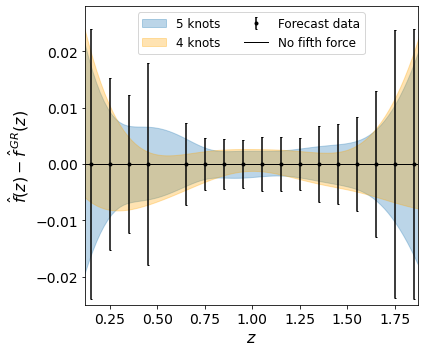

<Figure size 432x288 with 0 Axes>

In [33]:
### Plot
plt.figure(figsize=(6, 5))
plt.xlabel(gp_info["label_x"], fontsize=16)
plt.ylabel('$\\hat{f}(z)-\\hat{f}\\,{^{GR}}(z)$', fontsize=16)

# data
data = plt.errorbar(fhat_data_future["z"][0:], fhat_data_future["mean"][0:]-fhat_data_future["mean"][0:], fhat_data_future["err"][0:], fmt=".", capsize=1, 
             label="Mock data", color='black')

# Prediction without a fifth force
GR = plt.plot([0,2], [0,0], color = 'black',  linewidth = 1.0, label = 'No fifth force')[0]

# Spline 1 (baseline)
fill1 = plt.fill_between(z_range, fhat_spline_reco['mean'] - fhat_LCDM - fhat_stdev_spline, fhat_spline_reco['mean'] - fhat_LCDM + fhat_stdev_spline, 
                 color='C0', alpha=0.3, label = '5 knots')

# Spline 2

fill2 = plt.fill_between(z_range, fhat_spline_reco2['mean'] - fhat_LCDM - fhat_stdev_spline2, fhat_spline_reco2['mean'] - fhat_LCDM + fhat_stdev_spline2, 
                 color='orange', alpha=0.3, label = '4 knots')


ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# Set the x-axis ticks
plt.xlim(0.12,1.87)
plt.ylim(-0.025,0.028)
plt.xticks(ticks,fontsize=14)
plt.yticks(fontsize=14)

# Then, collect handles and labels manually
handles = [fill1, fill2, data, GR]
labels = ['5 knots', '4 knots', 'Forecast data', 'No fifth force']

# Then set the legend with desired order and spacing
plt.legend(handles, labels, fontsize=12, ncol=2, loc = 'upper center')

plt.tight_layout()

plt.savefig("fhat_future_4_5.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

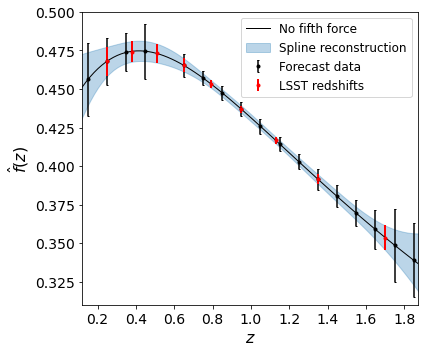

<Figure size 432x288 with 0 Axes>

In [37]:
### Plot
plt.figure(figsize=(6, 5))
plt.xlabel(gp_info["label_x"], fontsize=16)
plt.ylabel('$\\hat{f}(z)$', fontsize=16)

# GR prediction
GR = plt.plot(z_range, Gamma.fhat_LCDM(z_range), color = 'black',  linewidth = 1.0, label = 'No fifth force')[0]


# data
plt.errorbar(fhat_data_future["z"], fhat_data_future["mean"], fhat_data_future["err"], fmt=".", capsize=1, 
             label="Forecast data", color='black')

# spline
plt.fill_between(z_range, fhat_spline_reco['mean'] - fhat_stdev_spline,
    fhat_spline_reco['mean'] + fhat_stdev_spline, color='C0', alpha=0.3, label = 'Spline reconstruction')

plt.errorbar(z_LSST[0:-1],fhat_spline_reco_LSST['mean'][0:-1],np.sqrt(np.diag(fhat_spline_reco_LSST['cov']))[0:-1],
             color = 'red', fmt=".", linewidth = 2, label = 'LSST redshifts')


plt.xlim(0.12,1.87)
plt.ylim(0.31,0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("fhat_future.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

### Calculating dlnf(z) and Gamma(z) with covariances

In [38]:
Hprime_LSST = Gamma.Hprime(z_LSST)
confH_LSST = Gamma.E(z_LSST)/(1+z_LSST)

In [39]:
[Gamma_LSST, Gamma_cov_LSST, dlnf_mean_LSST, dlnf_cov_LSST]=Gamma.Gamma_reco(fhat_spline_reco_LSST, Jhat_reco_pess, include_cov01 = True)
err_Gamma_LSST = np.sqrt(np.diag(Gamma_cov_LSST))
err_dlnf_LSST = np.sqrt(np.diag(dlnf_cov_LSST))

In [40]:
[Gamma_LSST2, Gamma_cov_LSST2, dlnf_mean_LSST2, dlnf_cov_LSST2]=Gamma.Gamma_reco(fhat_spline_reco_LSST2, Jhat_reco_pess, include_cov01 = True)
err_Gamma_LSST2 = np.sqrt(np.diag(Gamma_cov_LSST2))
err_dlnf_LSST2 = np.sqrt(np.diag(dlnf_cov_LSST2))

In [41]:
[dlnf_mean, dlnf_cov] = Gamma.dlnf_dln1pz(fhat_spline_reco, include_cov01 = True)
err_dlnf = np.sqrt(np.diag(dlnf_cov))

[dlnf_mean2, dlnf_cov2] = Gamma.dlnf_dln1pz(fhat_spline_reco2, include_cov01 = True)
err_dlnf2 = np.sqrt(np.diag(dlnf_cov2))

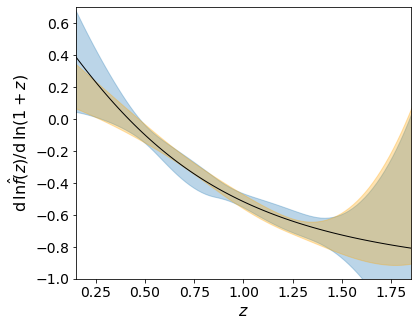

In [42]:
plt.figure(figsize=(6, 5))

#plt.errorbar([1], [-10], yerr = [0.01], fmt = '.', label = 'Forecasted $f\sigma_8$ data', color = 'black', elinewidth=1)
GR = plt.plot(z_range, dlnf_LCDM, color = 'black', label = 'No fifth force', linewidth = 1)


fill1 = plt.fill_between(
    fhat_spline_reco['x'],
    dlnf_mean - err_dlnf,
     dlnf_mean + err_dlnf,
    color='C0',
    alpha=0.3,
    label = '5 knots'
)

fill2 = plt.fill_between(
    fhat_spline_reco2['x'],
    dlnf_mean2 - err_dlnf2,
     dlnf_mean2 + err_dlnf2,
    color='orange',
    alpha=0.3,
    label = '4 knots'
)


plt.xlim(0.15,1.85) #min. and max. z values of DESI data
plt.ylim(-1.0,0.7)

#plt.legend(fontsize = 12)

ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# Set the x-axis ticks
plt.xticks(ticks, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\\mathrm{d}\,\ln\hat{f}(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)

plt.savefig("dlnf_forecast_4_5.png", dpi=600, bbox_inches='tight')

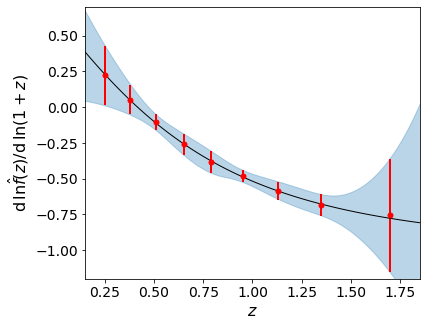

In [43]:
plt.figure(figsize=(6, 5))

plt.errorbar([1], [-10], yerr = [0.01], fmt = '.', label = 'Forecasted $f\sigma_8$ data', color = 'black', elinewidth=1)
plt.plot(z_range, dlnf_LCDM, color = 'black', label = 'No fifth force', linewidth = 1)


plt.errorbar(z_LSST, dlnf_mean_LSST, yerr=err_dlnf_LSST, fmt='.', markersize=10, elinewidth=2, 
             color = 'red', label = 'LSST redshifts')

plt.fill_between(
    fhat_spline_reco['x'],
    dlnf_mean - err_dlnf,
     dlnf_mean + err_dlnf,
    color='C0',
    alpha=0.3,
    label = 'Spline reconstruction'
)


plt.xlim(0.15,1.85) #min. and max. z values of DESI data
plt.ylim(-1.2,0.7)

#plt.legend(fontsize = 12)

ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# Set the x-axis ticks
plt.xticks(ticks, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\\mathrm{d}\,\ln\hat{f}(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)

plt.savefig("dlnf_forecast.png", dpi=600, bbox_inches='tight')

### Interpolation of Jhat

In [44]:
node_values_J = z_LSST

# Generate best fit values (for fhat at nodes) and cov matrix
[J_best_fit_spline, J_cov_spline] = intf.minuit_spline(node_values_J, z_data = z_LSST, fhat_data = Jhat_fiducial, fhat_data_covariance = Jhat_covariance_pess, use_covariance = True)

# Interpolate over the whole redshift range by generating 1000 samples
Jhat_spline_reco = intf.spline_interpolation(J_best_fit_spline, J_cov_spline, zarray = node_values_J, z_range = z_range, return_covariance = True)
Jhat_spline_reco_nodes = intf.spline_interpolation(J_best_fit_spline, J_cov_spline, zarray = node_values_J, z_range = node_values, return_covariance = True)

In [45]:
Jhat_stdev_spline = np.sqrt(np.diag(Jhat_spline_reco['cov']))

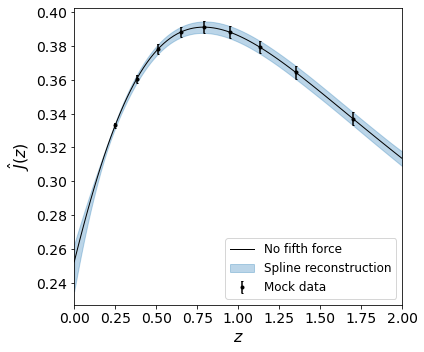

<Figure size 432x288 with 0 Axes>

In [46]:
### Plot
plt.figure(figsize=(6, 5))
plt.xlabel(gp_info["label_x"], fontsize=16)
plt.ylabel('$\\hat{J}(z)$', fontsize=16)
# data
plt.errorbar(z_LSST, Jhat_fiducial, np.sqrt(np.diag(Jhat_covariance_pess)), fmt=".", capsize=1, 
             label="Mock data", color='black')

# Prediction without a fifth force
plt.plot(z_range, Jhat_LCDM, color = 'black',  linewidth = 1, label = 'No fifth force')

# spline
#plt.plot(z_range, fhat_spline_reco['mean'], color='green', label="spline")
plt.fill_between(z_range, (Jhat_spline_reco['mean'] - Jhat_stdev_spline), (Jhat_spline_reco['mean'] + Jhat_stdev_spline), 
                 color='C0', alpha=0.3, label = 'Spline reconstruction')

ticks = [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]

# Set the x-axis ticks
plt.xticks(ticks,fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0,2)

plt.legend(fontsize=12)
plt.tight_layout()

#plt.savefig("Jhat_future.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

In [47]:
[Gamma_range, Gamma_cov_range]=Gamma.Gamma_reco(fhat_spline_reco, Jhat_spline_reco,  output_dlnz = False, include_cov01 = True)
err_Gamma_range = np.sqrt(np.diag(Gamma_cov_range))

In [48]:
[Gamma_range2, Gamma_cov_range2]=Gamma.Gamma_reco(fhat_spline_reco2, Jhat_spline_reco,  output_dlnz = False, include_cov01 = True)
err_Gamma_range2= np.sqrt(np.diag(Gamma_cov_range2))

### Gamma

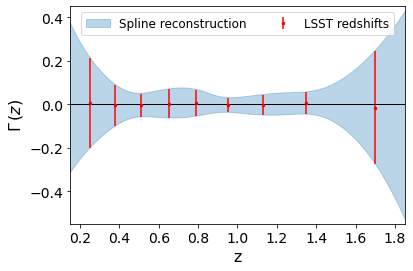

In [49]:
# plt.figure(figsize=(6, 5))

plt.plot(np.linspace(0.,2.0,50), np.full(50, 0), color='black', linewidth=1.0)


# Plot the measured data with larger markers and wider error bars
plt.fill_between(z_range, Gamma_range - 1-err_Gamma_range, Gamma_range - 1+err_Gamma_range, 
                 color = 'C0', alpha=0.3, label = 'Spline reconstruction')



# Plot the measured data with larger markers and wider error bars
plt.errorbar(z_LSST[:-1], Gamma_LSST[:-1] - 1, yerr=err_Gamma_LSST[:-1], fmt='.', markersize=5, 
             elinewidth=1.5, color = 'red', label = 'LSST redshifts')

plt.xlabel("z", fontsize=16)
plt.ylabel("$\Gamma\,(z)$", fontsize=16)
plt.xlim(0.15,1.85)
plt.ylim(-0.55, 0.45)
plt.legend(ncol = 2, loc = 'upper center', fontsize = 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("results_Gamma_forecast.png", dpi=600, bbox_inches='tight')

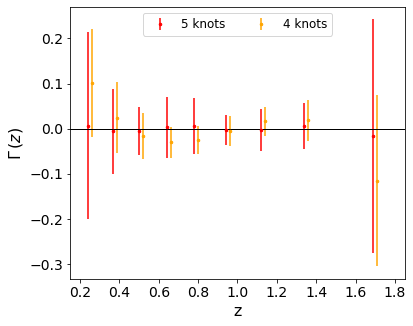

In [50]:
plt.figure(figsize=(6, 5))

plt.plot(np.linspace(0.,2.0,50), np.full(50, 0), color='black', linewidth=1.0)

# Plot the measured data with larger markers and wider error bars
plt.errorbar(z_LSST[:-1]-0.01, Gamma_LSST[:-1] - 1, yerr=err_Gamma_LSST[:-1], fmt='.', 
             markersize=5, elinewidth=1.5, color = 'red', label = '5 knots')
plt.errorbar(z_LSST[:-1]+0.01, Gamma_LSST2[:-1] - 1, yerr=err_Gamma_LSST2[:-1], fmt='.', 
             markersize=5, elinewidth=1.5, color = 'orange', label = '4 knots')
####

plt.xlabel("z", fontsize=16)
plt.ylabel("$\Gamma\,(z)$", fontsize=16)
plt.xlim(0.15,1.85)
#plt.ylim(-0.6, 0.4)
plt.legend(loc = 'upper center', fontsize = 12, ncol = 2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("results_Gamma_forecast_4_5.png", dpi=600, bbox_inches='tight')

# Test with Gaussian Processes

In [64]:
import os
#Download https://github.com/louisperenon/HCGP and then change the path as needed
os.chdir('/Users/nastassiagrimm/Documents/GitHub/EG_project/Jhat_fhat/HCGP')
from kernels import SquaredExponential, RationalQuadratic, Matern32
from master import Engine
import make_mocks as mocks
os.chdir('/Users/nastassiagrimm/Documents/GitHub/Fifthforce_Jhat_fhat')

In [52]:
#################
### GP config ###
#################
run_options = {
    "name_run": "test",
    "method": ["optimisation"],
    "print_chains": False,
    "print_plots": False,
}

gp_info = {
    "name_function": "fhat",
    "label_function": r"$\hat{f}(z)$",
    "label_x": r"$z$",
    "kernel": SquaredExponential(sigma="sigma1", xi="xi1"),
    "hyperpars": {
        "sigma1": {
            "label": r"\sigma",
            "range": [-5, 5], # this means that hyper parameter can range between -10^(5) and +10^5
            "sampling_invfunc": lambda x: 10 ** np.array(x),
        },
        "xi1": {
            "label": r"\xi",
            "range": [-5, 5],
            "sampling_invfunc": lambda x: 10 ** np.array(x),
        },
    },
    "mean_priors": {
        "mean": lambda x: 0 * x,
    },
    "derivatives": True,
}

In [53]:
# Gaussian process interpolation
fhat_data = {
        "x": z_DESI,
        "y": fhat_fiducial,
        "err": fhat_errors_opt/fhat_fiducial,
        "cov": np.diag((fhat_errors_opt/fhat_fiducial)**2),
    }

results = Engine(run_options, gp_info, fhat_data, True)
fhat_reco = results.get_optimised_reconstruction(z_range)
fhat_reco_LSST = results.get_optimised_reconstruction(z_LSST)


*** Minimisation results ***

> sigma1: bestfit = 0.34580436051909236; bestsamp = -0.4611695346669542 
> xi1: bestfit = 3.051864876817286; bestsamp = 0.48456530105488443 
> maxlnl = 40.894021027263605



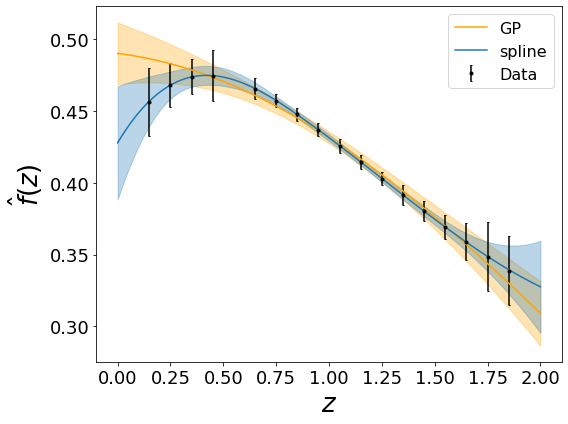

<Figure size 432x288 with 0 Axes>

In [54]:
### Plot comparing fhat interpolation for GP and spline interpolation
plt.figure(figsize=(8, 6))
plt.xlabel(gp_info["label_x"], fontsize=26)
plt.ylabel('$\\hat{f}(z)$', fontsize=26)
# data
plt.errorbar(fhat_data["x"], fhat_data["y"], fhat_data["err"]*fhat_data['y'], fmt=".", capsize=1, 
             label="Data", color='black')

# gp
plt.plot(fhat_reco["x"], fhat_reco["mean"], color='orange', label="GP")

plt.fill_between(fhat_reco["x"], fhat_reco["mean"] - fhat_reco["err"], fhat_reco["mean"] + fhat_reco["err"],
                 color='orange', alpha=0.3)

# spline
plt.plot(z_range, fhat_spline_reco['mean'], color='C0', label="spline")
plt.fill_between(z_range, fhat_spline_reco['mean'] - fhat_stdev_spline,
    fhat_spline_reco['mean'] + fhat_stdev_spline, color='C0', alpha=0.3)


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
#plt.savefig("f_forecast_GP_spline.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

In [55]:
#Derivate of fhat and Gamma for GP

[Gamma_LSST_GP, Gamma_cov_LSST_GP, dlnf_mean_LSST_GP, dlnf_cov_LSST_GP]=Gamma.Gamma_reco(fhat_reco_LSST, Jhat_reco_pess)
err_dlnf_LSST_GP = np.sqrt(np.diag(dlnf_cov_LSST_GP))

[dlnf_mean_GP, dlnf_cov_GP] = Gamma.dlnf_dln1pz(fhat_reco)
err_dlnf_GP = np.sqrt(np.diag(dlnf_cov_GP))

dlnf_GP = fhat_reco['mean_d1']*(1+fhat_reco['x'])/fhat_reco['mean']
err_dlnf_GP = np.sqrt(np.diag(dlnf_cov_GP))

dlnf_LSST_GP = fhat_reco_LSST['mean_d1']*(1+fhat_reco_LSST['x'])/fhat_reco_LSST['mean']
err_dlnf_LSST_GP = np.sqrt(np.diag(dlnf_cov_LSST_GP))

Text(0, 0.5, '$\\mathrm{d}\\,\\ln f(z)/\\mathrm{d}\\,\\ln(1+z)$')

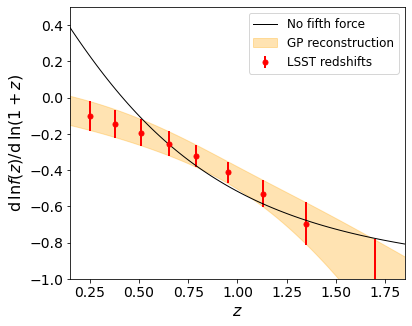

In [58]:
# Plot derivative of fhat for GP
plt.figure(figsize=(6, 5))

plt.plot(z_range, dlnf_LCDM, color = 'black', label = 'No fifth force', linewidth = 1)


plt.errorbar(z_LSST, dlnf_mean_LSST_GP, yerr=err_dlnf_LSST_GP, fmt='.', markersize=10, elinewidth=2, 
             color = 'red', label = 'LSST redshifts')

plt.fill_between(
    fhat_reco['x'],
    dlnf_mean_GP - err_dlnf_GP,
     dlnf_mean_GP + err_dlnf_GP,
    color='orange',
    alpha=0.3,
    label = 'GP reconstruction'
)

plt.xlim(0.15,1.85)
plt.ylim(-1.,0.5)

plt.legend(fontsize = 12)

ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# Set the x-axis ticks
plt.xticks(ticks, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\\mathrm{d}\,\ln f(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)

#plt.savefig("dlnf_forecast_GP.png", dpi=600, bbox_inches='tight')